In [1]:
import awkward as ak
import numpy as np
import time
# print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import mplhep as hep

In [2]:
# from plugins import handleData
# redirector = 'root://xcache/'
# files = handleData('fileset_QCD.json', redirector, year = 2018, testing = True, data = False)
# events = NanoEventsFactory.from_root(list(files.values())[0][0], schemaclass=NanoAODSchema).events()
# print(events.fields)

In [60]:
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm, poisson
from scipy.special import erf, erfinv

def fit_function(x, b, c):
    y = 0.5*(1+erf((x-b)/c))
    return y

#params = b, c, scale

def negLL(params, x, data):
    #x is the pt bin centers, y is the prediction, data is the real y values
    std_dev = 1.
    y = fit_function(x, *params)
    #### add rv_continuous and make MLE fit from that
    negLL = -np.sum(np.log(y))
    return negLL
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    x0 = [200., 100.]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    result = minimize(negLL, x0 = popt, args= (x, data))
    print("Basic fit results: ", popt)
    ###
    print("MLE results: ", result.get("jac"))
    return result.get("jac"), popt

import matplotlib.pyplot as plt
plt.style.use([hep.style.CMS, hep.style.firamath])
import hist 
from plugins import checkdir
def plot_turnOn(result, HLT):
    hist_trigEff = result['hist_trigEff_ptCut']
    hist_trigRef = result['hist_trigRef']
    hist_pt = result['hist_pt']
    HLT_paths = [path for path in list(hist_trigEff.project("HLT_cat").axes[0])]
    dataset = hist_trigEff[{"HLT_cat":slice(0,hist.overflow-1,sum)}].axes[0][0]
    os_path = 'plots/triggerStudies'+ dataset + 'Testing/'
    checkdir(os_path)
    print('HLT_paths:', HLT_paths)
    trigThresh = [int(path.replace(HLT, '')) for path in HLT_paths]
    turnOnPts = {}
    turnOnPts_ptCut = {}
    for i in np.arange(len(HLT_paths)):
        path = HLT_paths[i]
        print("Path = ", path)
        print("dataset: ", dataset)
        print("trigeffvalues for path: ", hist_trigEff[{"HLT_cat":path}])
        #### numerator is number of events that belong to trigger path below and have pt > current trigger thresh
        numerator = hist_trigEff[{"HLT_cat":path}].values()[0]
        print("Numerator:", numerator)
        #### denominator is number of events in 
        denominator = hist_trigRef[{"HLT_cat":path}].values()[0]
        print("Length of num:", len(numerator), " Length of denom: ", len(denominator))
        num = numerator[denominator > 0]
        denom = denominator[denominator > 0]
        print("Length of num:", len(num), " Length of denom: ", len(denom), " after removing zeros.")
        efficiency = num / denom
        print("Number of bins:", len(hist_trigEff.axes['pt'].centers))
        #need to fix following line (how and why??)
        print("Pt bin centers:", hist_trigEff.axes['pt'].centers[denominator > 0])
        pt_centers = hist_trigEff.axes['pt'].centers[denominator > 0]
        
        print("Length of efficiency:", len(efficiency))
        #### plot original numerator and denominator histograms
        fig, ax = plt.subplots(1, 1)
        hist_trigEff[{"HLT_cat":path}].plot1d(ax=ax)
        hist_trigRef[{"HLT_cat":path}].plot1d(ax=ax)
        ax.set_title("Events in HLT " + HLT_paths[i-1])
        ax.set_xlabel("Leading Jet pT (GeV)")
        ax.set_ylim(1, None)
        ax.legend(["Numerator", "Numerator_ptCut", "Denominator"])
        plt.savefig(os_path + 'numDenom_HLT_' + path + ".png")
        #### Make custom fit function for the efficiencies
        if len(efficiency) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.set_ylim([-0.01, 1.1])
            ##### INSTEAD START AT MAXIMUM AND MARCH DOWN or CHOOSE POINT ON TURN ON
            # print("Efficiency: ", efficiency)
            eff_turnon_id = np.min(np.argwhere(trigThresh[i] <= pt_centers))
            print("eff_turnon_id = ", eff_turnon_id)
            print("pt of turn on = ", pt_centers[eff_turnon_id])
            #jac, popt = fit_trigEff(pt_centers[eff_turnon_id:-1], efficiency[eff_turnon_id:-1])
            jac, popt = fit_trigEff(pt_centers, efficiency)
            xpts = np.linspace(0, 2400, 2400)
            print("Curve_fit: ", popt)
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            b, c = popt
            to_pt = (c*erfinv(2*0.99-1)) + b
            turnOnPts[path] = to_pt
            ax.scatter(hist_trigEff.axes['pt'].centers[denominator > 0], efficiency, label = 'HLT_' + path)
            # ax.plot(xpts, 0.5*(1+erf((xpts-trigThresh[i])/trigThresh[i-1])), label = "Test")
            ax.plot(xpts, fit_function(xpts, *popt), label = "Curve fit; to_pt = %.f"%to_pt)
            ax.set_xlabel("Leading Jet pT (GeV)")
            ax.legend()
            plt.savefig(os_path + 'efficiency_HLT_' + path + ".png")
    #### plot total leading jet pt for reference
    fig, ax = plt.subplots(1, 1)
    hist_pt.plot1d(ax=ax)
    hist_trigEff.plot1d(ax=ax)
    ax.set_title("All events")
    ax.set_xlabel("Leading Jet pT (GeV)")
    ax.set_ylim(1, None)
    ax.set_xlim([180., 3200.])
    plt.savefig(os_path + 'HLT_' + path + ".png")
    
    return turnOnPts, turnOnPts_ptCut

def applyPrescales_lazy(result):
    
    return result
    

In [61]:
# ### Now have to convert ratio plot/fitter into a function that runs over the histograms
# ### or can cutflow all the values that go into the ratio plots and make values/1D histograms
# HLT = 'AK8PFJet'
# result = util.load('coffeaOutput/DiJet_2016_QCDsim_Testing_PFJet_result.coffea')
# print(result['hist_trigEff'].sum('HLT_cat').sum('pt').values())
# turnOnPts, turnOnPts_ptCut = plot_turnOn(result, HLT)
# print(turnOnPts_ptCut)
# print(turnOnPts)

HLT_paths: ['AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
Path =  AK8PFJet60
dataset:  JetHT2016
trigeffvalues for path:  Hist(
  StrCategory(['JetHT2016'], growth=True, name='dataset', label='Dataset'),
  Regular(100, 0, 2400, name='pt', label='Jet pT (GeV)'),
  storage=Weight()) # Sum: WeightedSum(value=2943, variance=2943)
Numerator: [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.20e+03
 7.72e+02 3.95e+02 2.29e+02 1.12e+02 8.70e+01 4.60e+01 3.40e+01 1.20e+01
 1.70e+01 1.10e+01 7.00e+00 1.00e+00 8.00e+00 2.00e+00 1.00e+00 1.00e+00
 2.00e+00 2.00e+00 1.00e+00 2.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00

ValueError: too many values to unpack (expected 1)

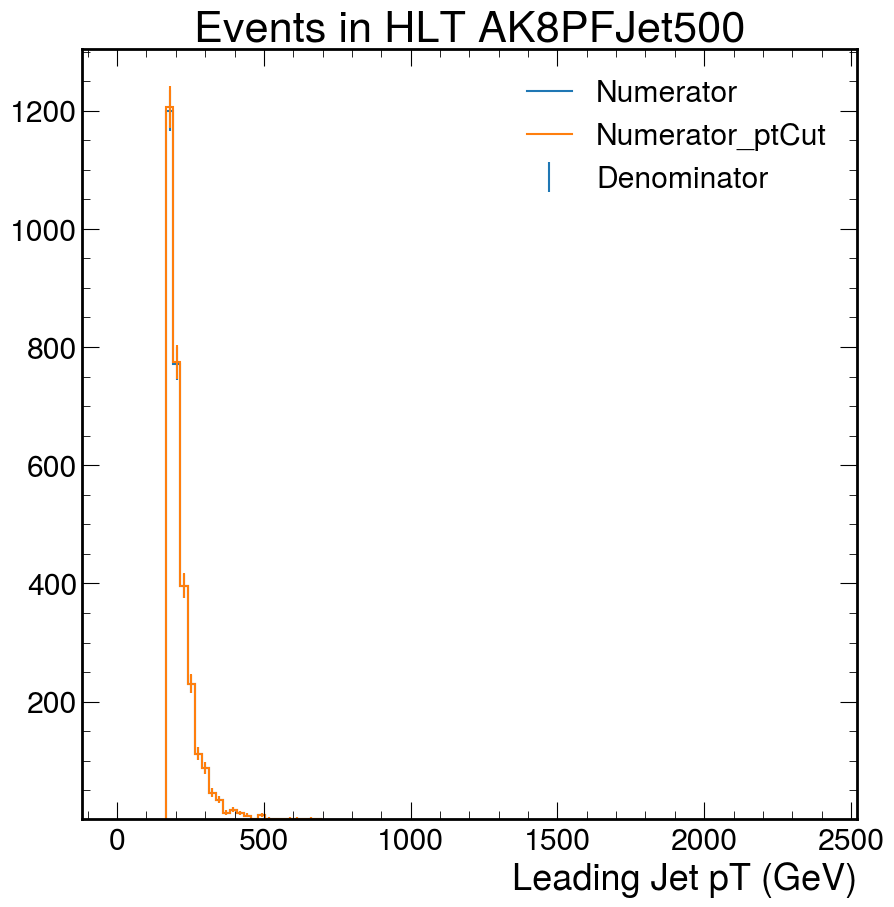

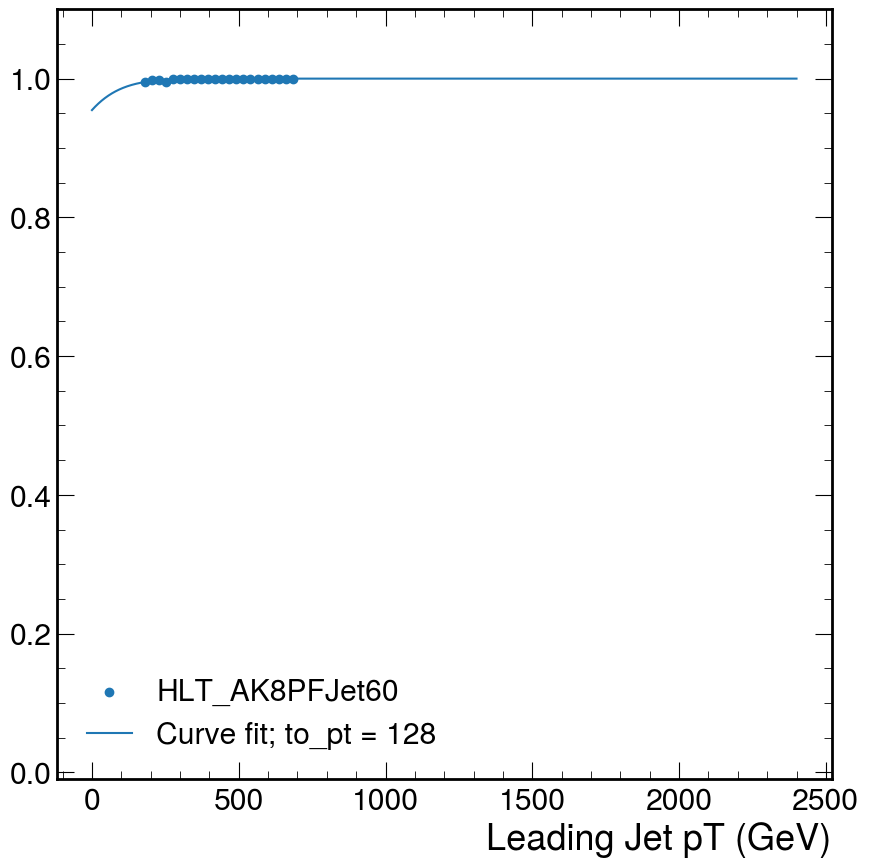

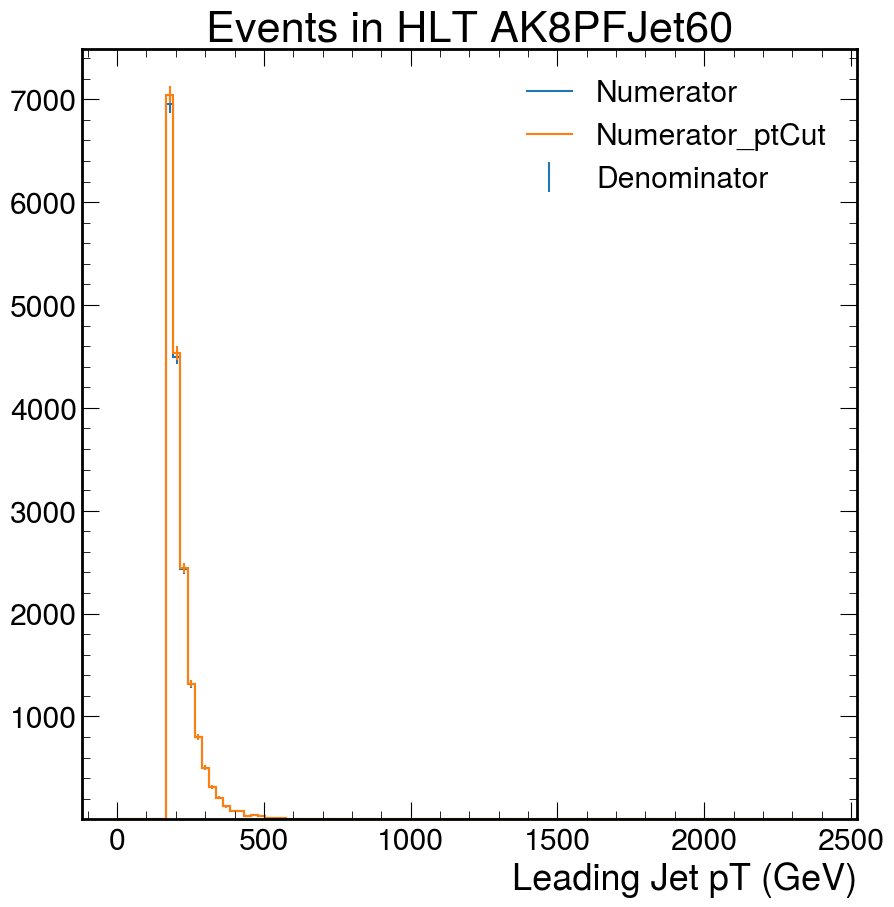

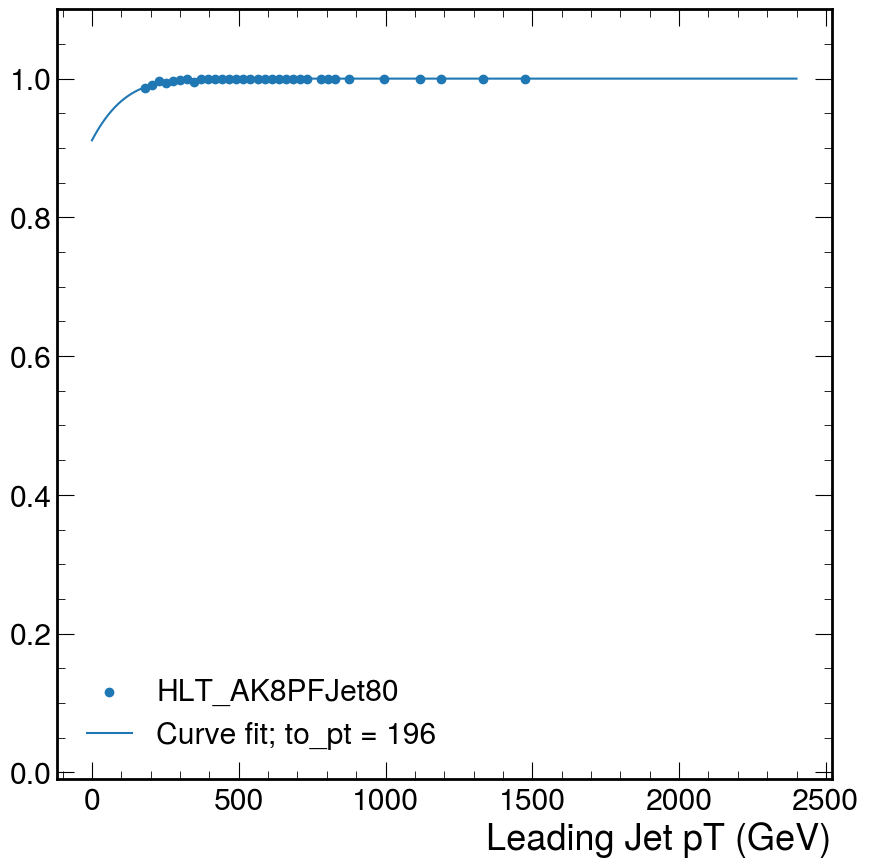

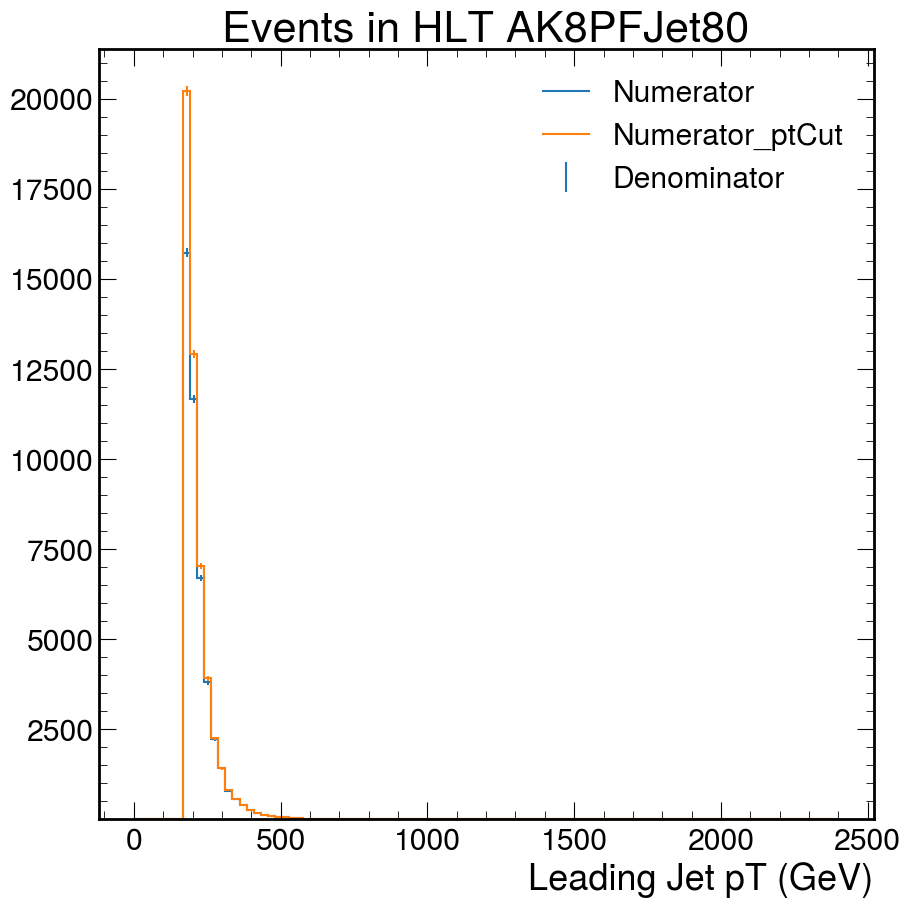

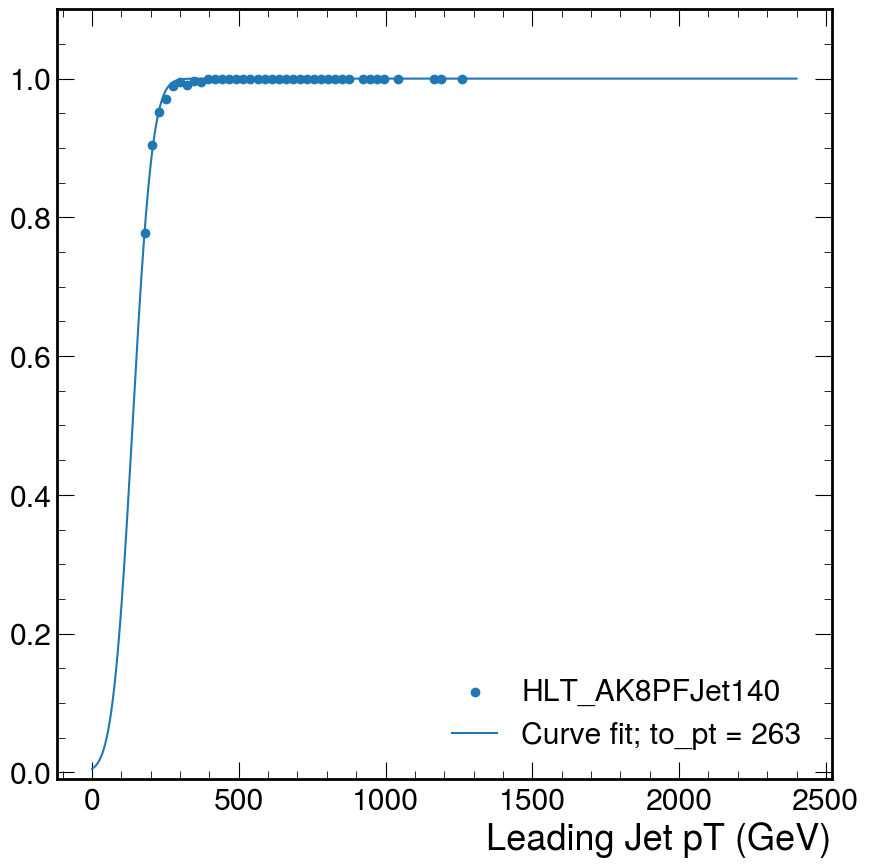

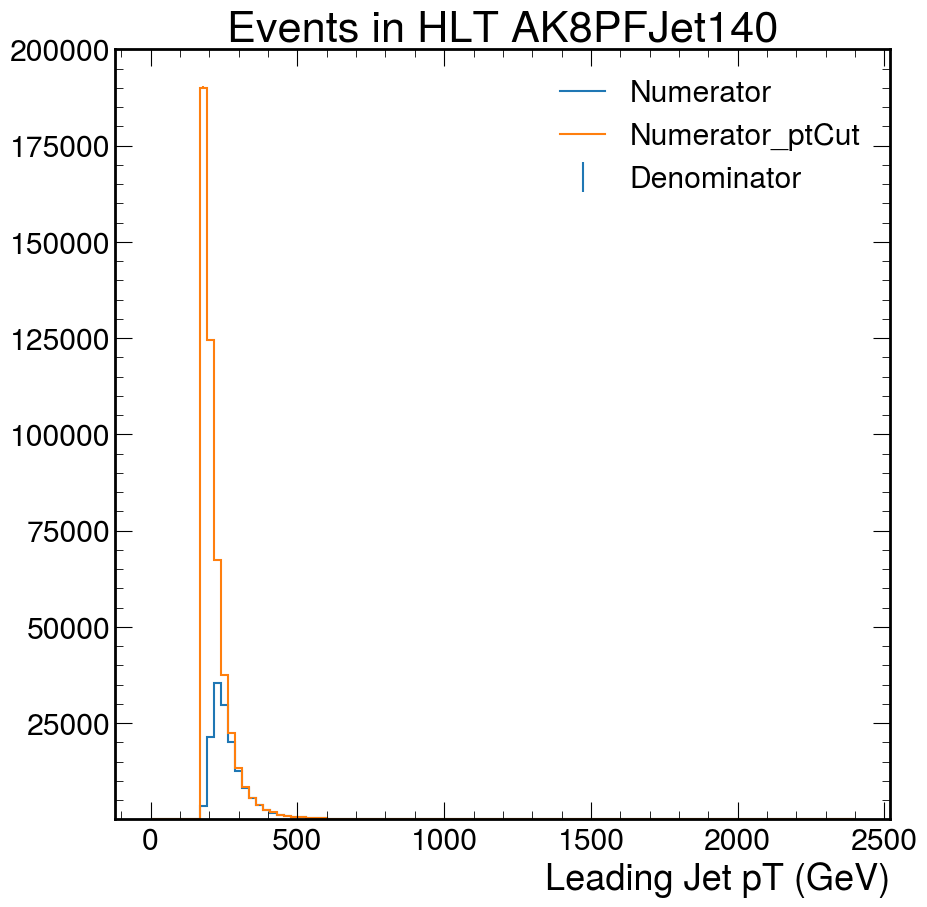

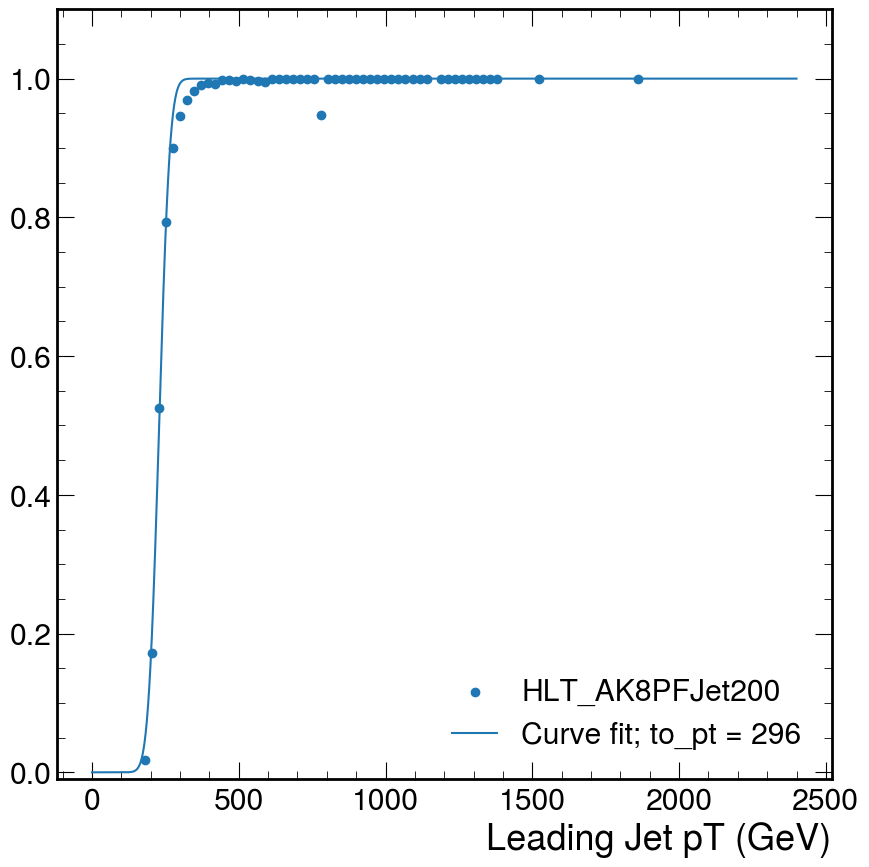

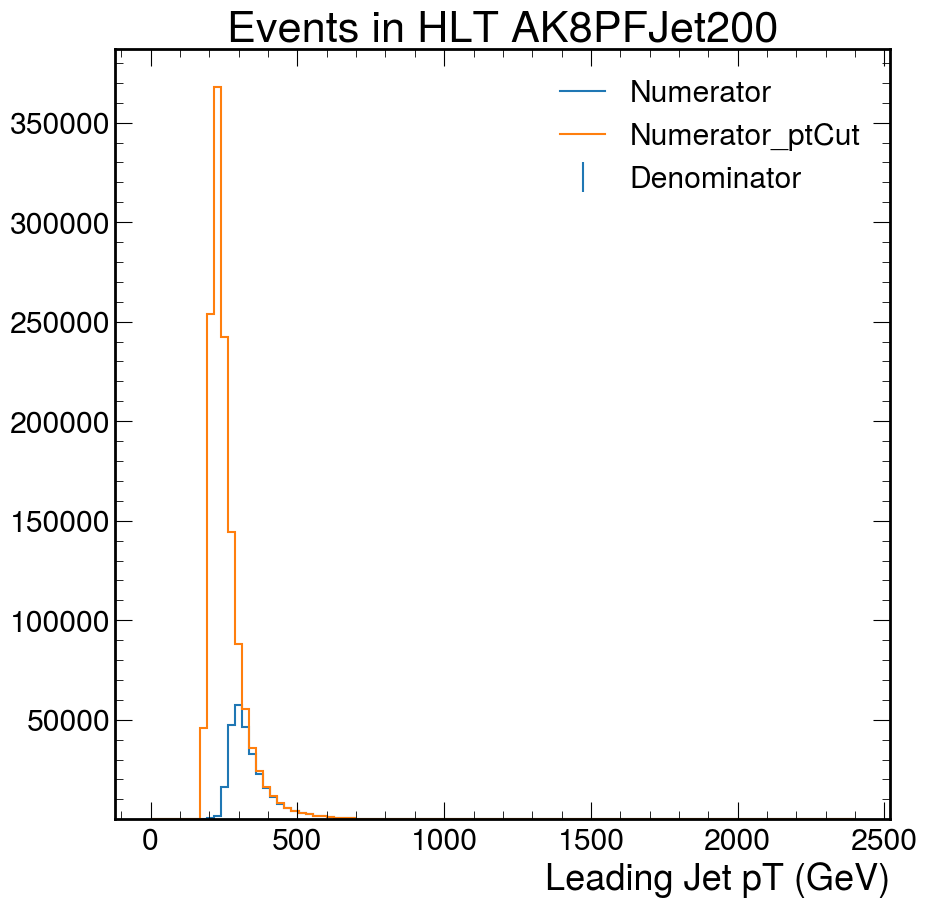

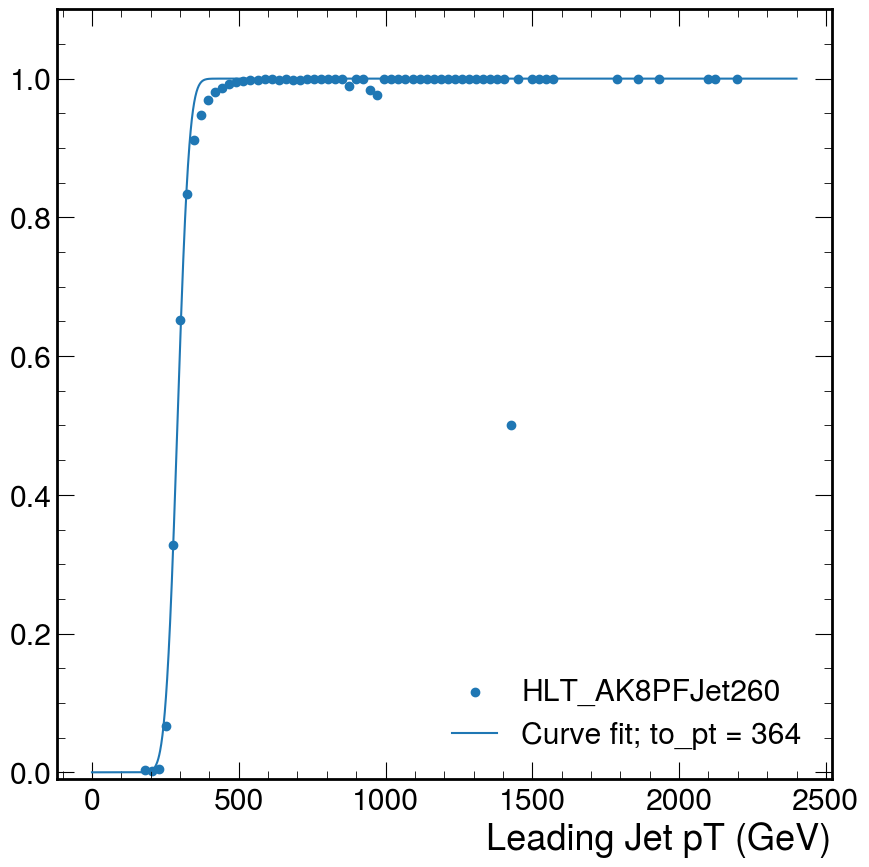

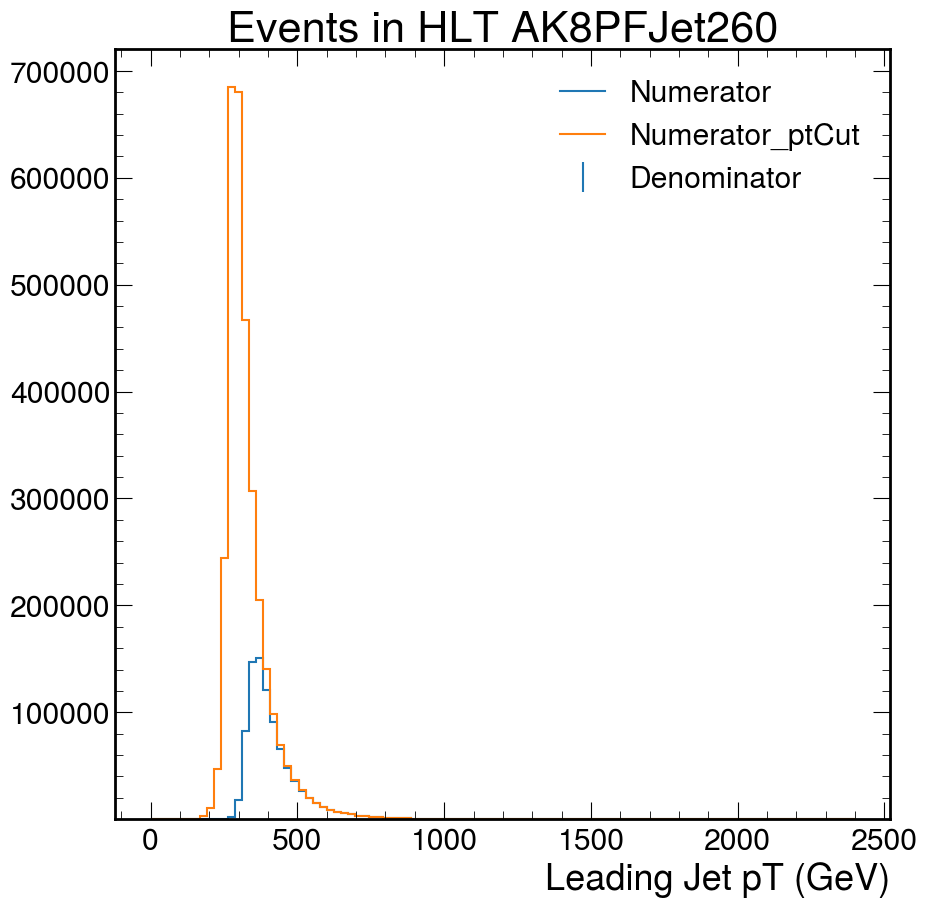

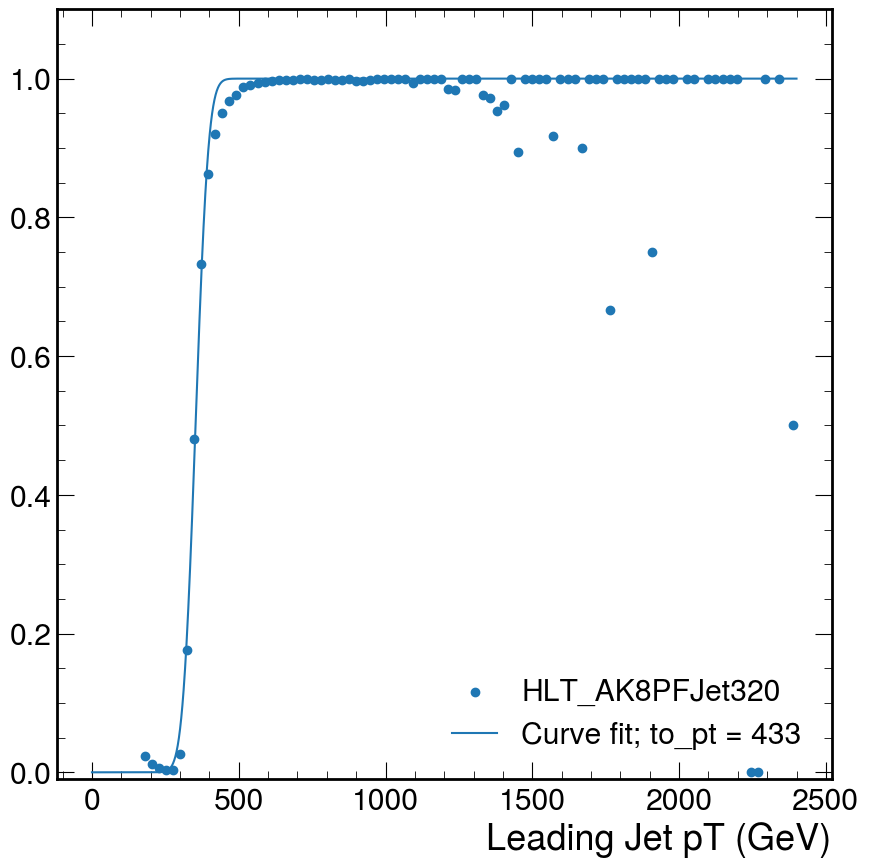

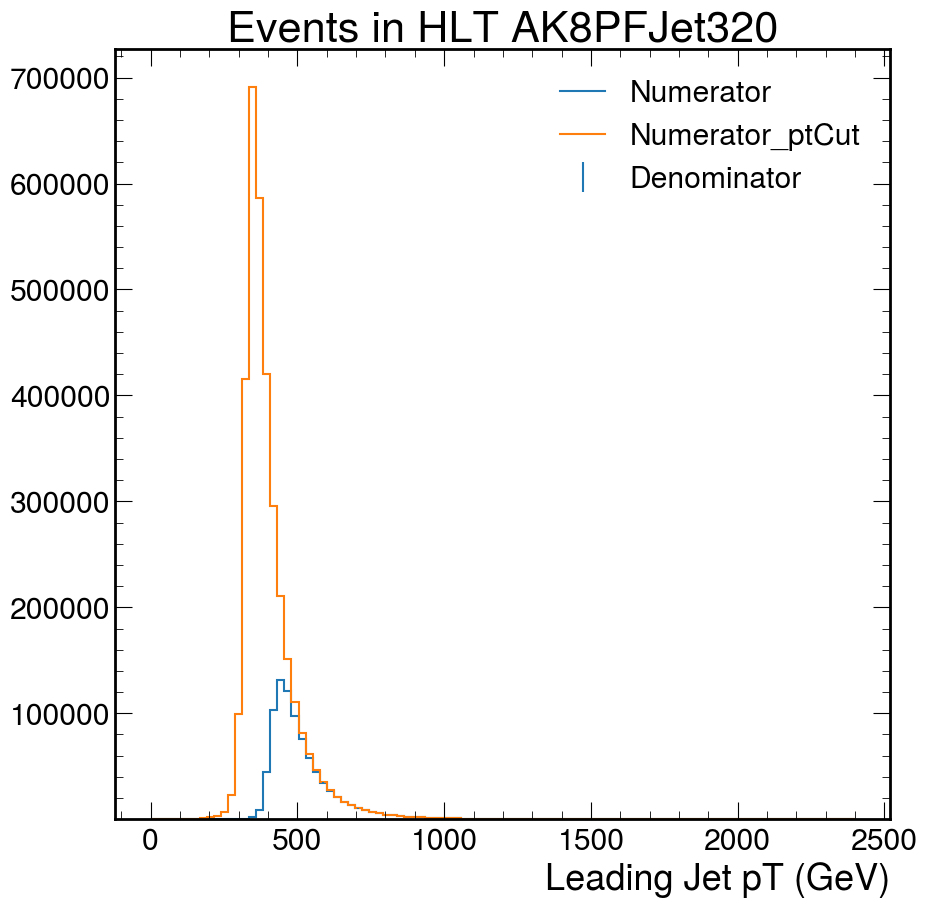

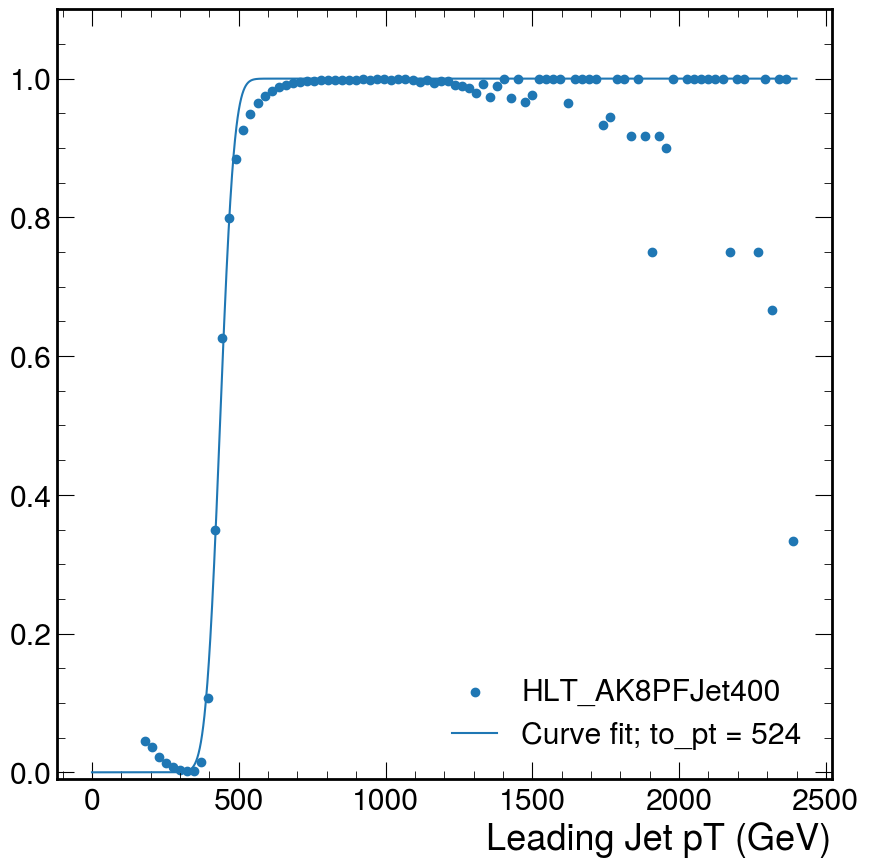

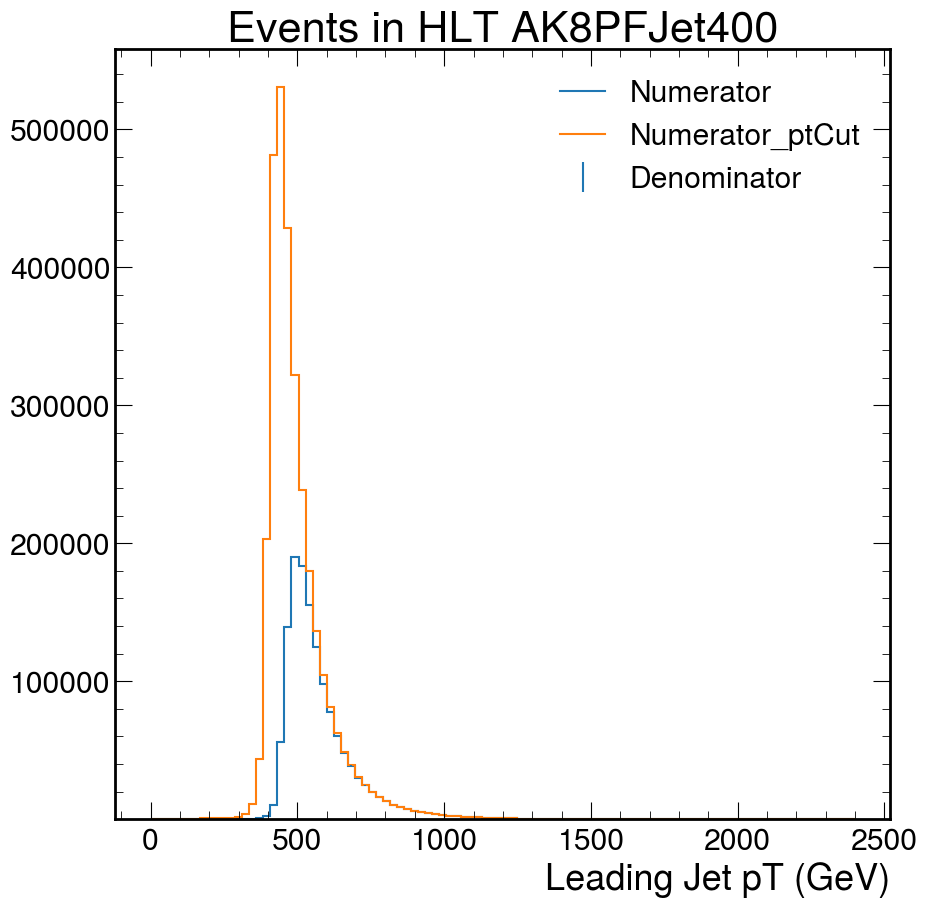

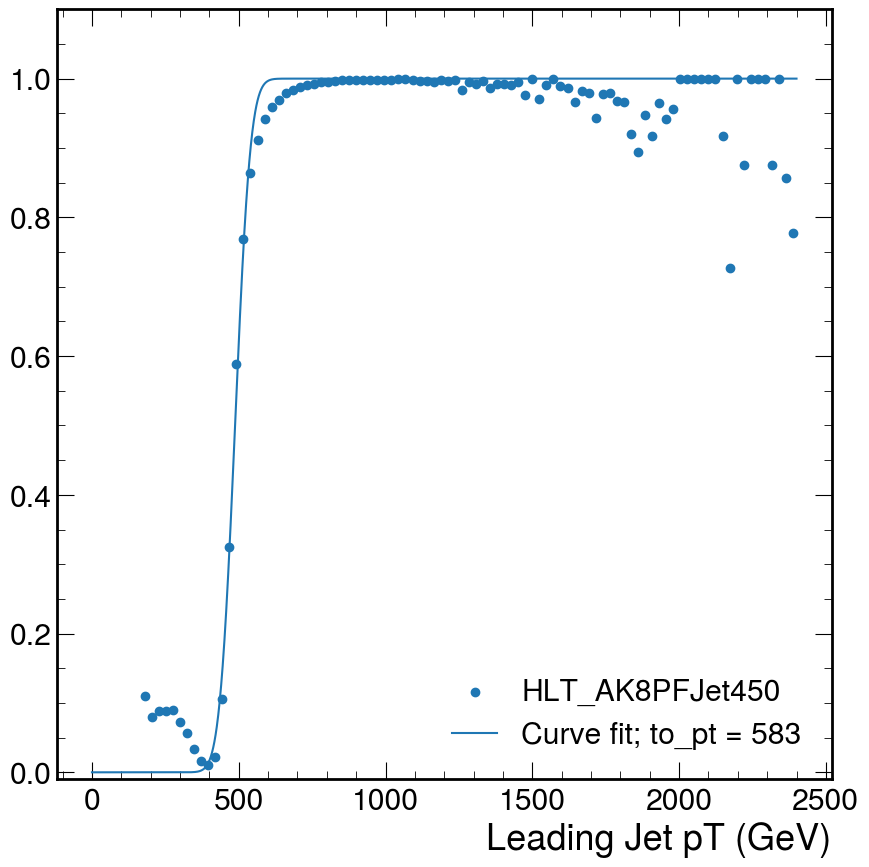

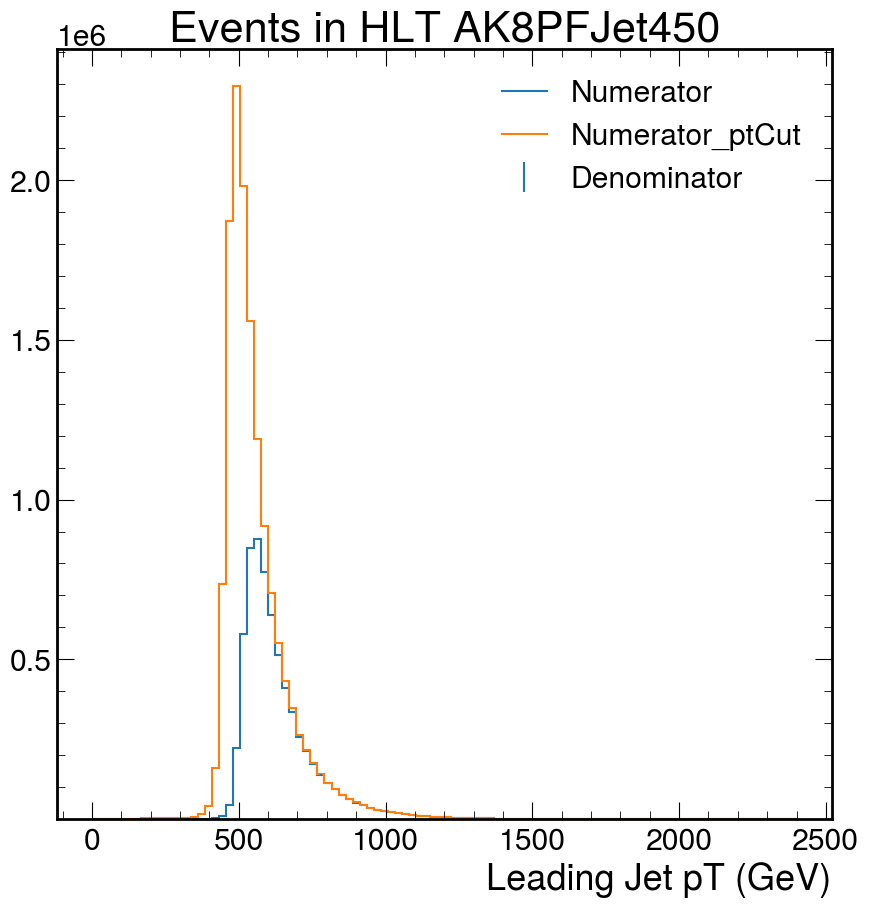

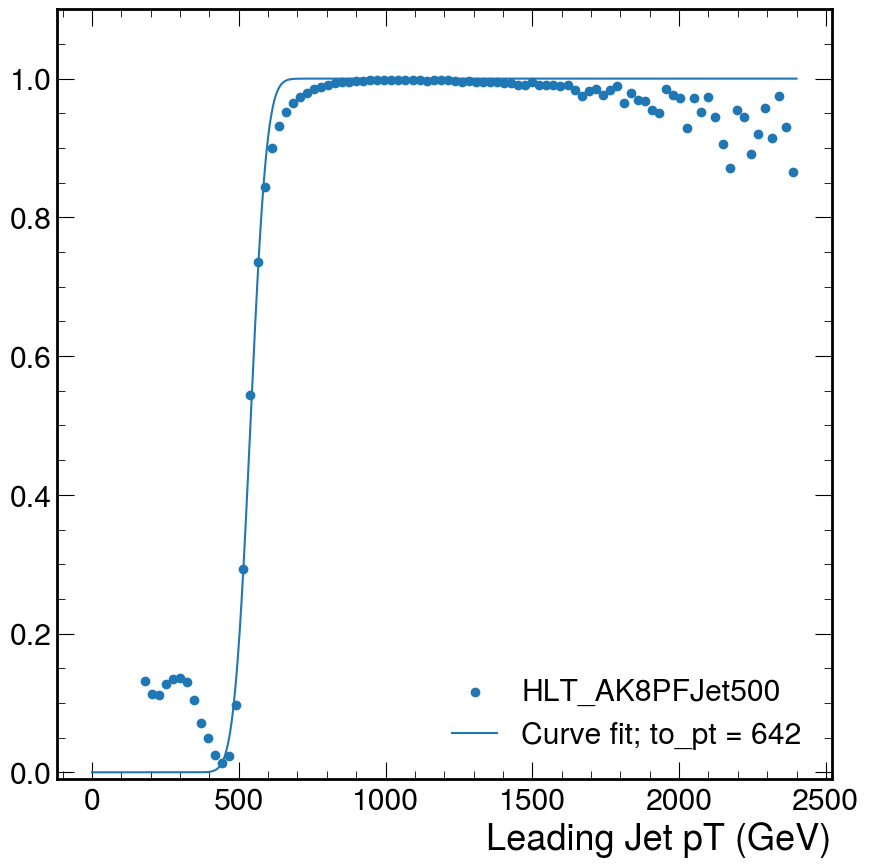

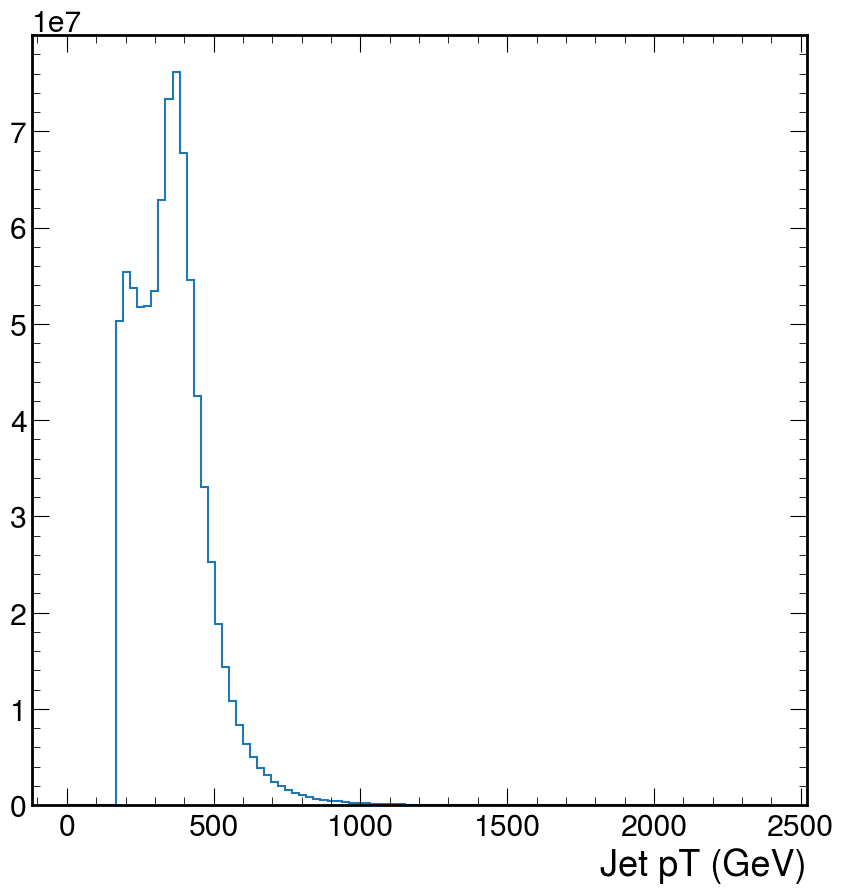

In [62]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/triggerAssignment_JetHT_2016_AK8PFJet_NewHist.coffea')
turnOnPts, turnOnPts_ptCut = plot_turnOn(result, HLT)
print(turnOnPts, turnOnPts_ptCut)

In [ ]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/triggerAssignment_QCDsim_2017_AK8PFJet_NewHist.coffea')
turnOnPts, turnOnPts_ptCut = plot_turnOn(result, HLT)
print(turnOnPts, turnOnPts_ptCut)

In [ ]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/triggerAssignment_QCDsim_2016_AK8PFJet_test_NewHist.coffea')
turnOnPts, turnOnPts_ptCut = plot_turnOn(result, HLT)
print(turnOnPts, turnOnPts_ptCut)

In [ ]:
HLT = 'AK8PFJet'
result = util.load('coffeaOutput/triggerAssignment_JetHT_2016_AK8PFJet_test_NewHist.coffea')
turnOnPts, turnOnPts_ptCut = plot_turnOn(result, HLT)
print(turnOnPts, turnOnPts_ptCut)

In [ ]:

turnOnPts_2016_JetHT = {'AK8PFJet40':0.,
                        'AK8PFJet60': 128., 
                        'AK8PFJet80': 196., 
                        'AK8PFJet140': 262.,
                        'AK8PFJet200': 296., 
                        'AK8PFJet260': 364., 
                        'AK8PFJet320': 433.,
                        'AK8PFJet400': 524.,
                        'AK8PFJet450': 583.,
                        'AK8PFJet500': 642.}
turnOnPts_2017_JetHT = {'AK8PFJet40':0.,
                        'AK8PFJet60': 89., 
                        'AK8PFJet80': 160.,
                        'AK8PFJet140': 254.,
                        'AK8PFJet200': 309.,
                        'AK8PFJet260': 381.,
                        'AK8PFJet320': 454.,
                        'AK8PFJet400': 546., 
                        'AK8PFJet450': 608.,
                        'AK8PFJet500': 669.,
                        'AK8PFJet550': 731.}
turnOnPts_2018_JetHT = {'AK8PFJet15': 0.,
                        'AK8PFJet25': 0.,
                        'AK8PFJet40': 0.,
                        'AK8PFJet60': 0., 
                        'AK8PFJet80': 164., 
                        'AK8PFJet140': 252.,
                        'AK8PFJet200': 305.,
                        'AK8PFJet260': 379.,
                        'AK8PFJet320': 451.,
                        'AK8PFJet400': 544.,
                        'AK8PFJet450': 609.,
                        'AK8PFJet500': 668.,
                        'AK8PFJet550': 727.}

turnOnPts_2016_QCDSim = {'AK8PFJet40':0.,
                         'AK8PFJet60': 0.,
                         'AK8PFJet80': 103.7431245681197,
                         'AK8PFJet140': 250.23583948077737,
                         'AK8PFJet200': 301.2418029415817,
                         'AK8PFJet260': 357.96787539254467,
                         'AK8PFJet320': 435.2061611936324,
                         'AK8PFJet400': 516.5390073904625,
                         'AK8PFJet450': 562.8044746691382,
                         'AK8PFJet500': 629.5738066119139}

turnOnPts_2017_QCDSim = {'AK8PFJet60': 0.,
                         'AK8PFJet80': 106.04213984155606,
                         'AK8PFJet140': 245.63662455880666,
                         'AK8PFJet200': 305.7948712092066,
                         'AK8PFJet260': 361.2655624387622,
                         'AK8PFJet320': 447.21717573414594,
                         'AK8PFJet400': 530.4549735674909,
                         'AK8PFJet450': 587.3825806338202,
                         'AK8PFJet500': 654.0716446127442,
                         'AK8PFJet550': 705.9374327651158 }

turnOnPts_2018_QCDSim = {'AK8PFJet15': 0.,
                        'AK8PFJet25': 0.,
                        'AK8PFJet40': 0.,
                        'AK8PFJet60': 0., 
                        'AK8PFJet80': 0., 
                        'AK8PFJet140': 0.,
                        'AK8PFJet200': 0.,
                        'AK8PFJet260': 0.,
                        'AK8PFJet320': 0.,
                        'AK8PFJet400': 0.,
                        'AK8PFJet450': 0.,
                        'AK8PFJet500': 0.,
                        'AK8PFJet550': 0.}


In [ ]:
HLT = "AK8PFJet"
result = util.load('coffeaOutput/DiJet_2018_QCDsim_AK8prescale_result.coffea')
turnOnPts = plot_turnOn(result, HLT)
print(turnOnPts)

In [ ]:
#TO DO: if statement to add prefix "HLT_" if using uproot --> 
###now switch to just coffea
#### THESE ARE NOT FINAL VALUES - NEED TO MAKE TURNON PLOTS
year = 2018
trigger = 'AK8PFJet'

if year == 2016:
    # HLT_paths = ['AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500']
    trigThresh = [40, 60, 80, 140, 200, 260, 320, 400, 450, 500]
    pt_bins = [0.0, 20., 40., 60., 80., 100., 110., 128.0, 150., 170., 180., 196.0, 220., 240., 250., 262.0, 280., 296.0, 320., 340., 350.,364.0, 380., 400., 420.,433.0, 450.,470.,490., 510., 524.0, 550., 570., 583.0,600.,620.,630., 642.0,800., 1000.,1200., 1600., 2000.,2400.,]
    HLT_paths = [trigger + str(i) for i in trigThresh]
    turnOnPts = {'AK8PFJet40':0.,
                        'AK8PFJet60': 128., 
                        'AK8PFJet80': 196., 
                        'AK8PFJet140': 262.,
                        'AK8PFJet200': 296., 
                        'AK8PFJet260': 364., 
                        'AK8PFJet320': 433.,
                        'AK8PFJet400': 524.,
                        'AK8PFJet450': 583.,
                        'AK8PFJet500': 642.}
    prescales = {
    'AK8PFJet40'  : 136006.59,
    'AK8PFJet60'  : 50007.75,
    'AK8PFJet80'  : 13163.18,
    'AK8PFJet140' : 1501.12,
    'AK8PFJet200' : 349.82,
    'AK8PFJet260' : 61.17,
    'AK8PFJet320' : 20.49,
    'AK8PFJet400' : 6.99,
    'AK8PFJet450' : 1.00,
    'AK8PFJet500' : 1.00
            }
    tot_lumi = 36.31
    file = "root://xcache//store/data/Run2016H/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/0290F73B-A51C-A441-AEC1-8429F9CC8AA8.root"
elif year == 2017:
    # HLT_paths = ['AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet550']
    trigThresh = [40, 60, 80, 140, 200, 260, 320, 400, 450, 500, 550]
    pt_bins = list(turnOnPts_2017_JetHT.values())
    HLT_paths = [trigger + str(i) for i in trigThresh]
    prescales = {'AK8PFJet40'  : 86061.17, 
                 'AK8PFJet60'  : 36420.75,    
                 'AK8PFJet80'  : 9621.74,    
                 'AK8PFJet140' : 1040.40,  
                 'AK8PFJet200' : 189.54,      
                 'AK8PFJet260' : 74.73,     
                 'AK8PFJet320' : 29.49,      
                 'AK8PFJet400' : 9.85,       
                 'AK8PFJet450' : 3.97,       
                 'AK8PFJet500' : 1.00,       
                 'AK8PFJet550' : 1.00,
    }
    turnOnPts = {'AK8PFJet40':0.,
                 'AK8PFJet60': 89., 
                 'AK8PFJet80': 160.,
                 'AK8PFJet140': 254.,
                 'AK8PFJet200': 309.,
                 'AK8PFJet260': 381.,
                 'AK8PFJet320': 454.,
                 'AK8PFJet400': 546., 
                 'AK8PFJet450': 608.,
                 'AK8PFJet500': 669.,
                 'AK8PFJet550': 731.}
    tot_lumi = 41.48
    file = 'root://xcache//store/data/Run2017D/JetHT/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/120000/018D975F-EA22-8F4B-84AC-796AF259675A.root'
elif year == 2018:
    # HLT_paths = ['AK8PFJet15', 'AK8PFJet25', 'AK8PFJet40', 'AK8PFJet60', 'AK8PFJet80', 'AK8PFJet140', 'AK8PFJet200', 'AK8PFJet260', 'AK8PFJet320', 'AK8PFJet400', 'AK8PFJet450', 'AK8PFJet500', 'AK8PFJet550']
    trigThresh = [15, 25, 40, 60, 80, 140, 200, 260, 320, 400, 450, 500, 550]
    pt_bins = list(turnOnPts_2018_JetHT.values())
    HLT_paths = [trigger + str(i) for i in trigThresh]
    prescales = {'AK8PFJet15'  : 318346231.66,
                 'AK8PFJet25'  : 318346231.66,
                 'AK8PFJet40'  : 248642.75,
                 'AK8PFJet60'  : 74330.16,  
                 'AK8PFJet80'  : 11616.52,   
                 'AK8PFJet140' : 1231.88, 
                 'AK8PFJet200' : 286.14,    
                 'AK8PFJet260' : 125.78,   
                 'AK8PFJet320' : 32.66,   
                 'AK8PFJet400' : 15.83,      
                 'AK8PFJet450' : 7.96,      
                 'AK8PFJet500' : 1.00,  
                 'AK8PFJet550' : 1.00,   
    }
    tot_lumi = 59.83
    turnOnPts = {'AK8PFJet15': 0.,
                 'AK8PFJet25': 0.,
                 'AK8PFJet40': 0.,
                 'AK8PFJet60': 0., 
                 'AK8PFJet80': 164., 
                 'AK8PFJet140': 252.,
                 'AK8PFJet200': 305.,
                 'AK8PFJet260': 379.,
                 'AK8PFJet320': 451.,
                 'AK8PFJet400': 544.,
                 'AK8PFJet450': 609.,
                 'AK8PFJet500': 668.,
                 'AK8PFJet550': 727.}
    file = 'root://xcache//store/data/Run2018A/JetHT/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v2/100000/00AA9A90-57AA-D147-B4FA-54D6D8DA0D4A.root'
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()
print(HLT_paths)

In [ ]:
# import triggerProcessor
# from triggerProcessor import applyPrescales
# prescaleResult = runCoffeaJob(applyPrescales(), jsonFile = "fileset_QCD.json", casa = True, dask = True, testing = True, year = 2018)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
events = events[ak.num(events.FatJet) >= 1]
print(len(events))
dataset_cat = hist.Cat("dataset", "Dataset")         
HLT_cat = hist.Cat("HLT_cat", "")
# pt_bin = hist.Bin("pt", "Jet pT (GeV)", pt_bins)
pt_bin = hist.Bin("pt", "Jet pT (GeV)", 500, 0, 2400)
hist_pt = hist.Hist("Events", dataset_cat, HLT_cat, pt_bin)
hist_pt_byHLTpath = hist.Hist("Events", dataset_cat, HLT_cat, pt_bin)

for i in np.arange(len(HLT_paths))[::-1]:
    path = HLT_paths[i]
    if path in events.HLT.fields:
        print("Index i: ", i, " for path: ", path)
        pt0 = events.FatJet[:,0].pt
        hist_pt.fill(dataset = "datastring", HLT_cat = path, pt = pt0[events.HLT[path]])
        if i == (len(HLT_paths) - 1):
            print('last index')
            pt_cut = (pt0 >= turnOnPts[HLT_paths[i]]) & events.HLT[path]
            hist_pt_byHLTpath.fill(dataset = "datastring", HLT_cat = path, pt = pt0[pt_cut])
        else:
            pt_cut = (pt0 >= turnOnPts[HLT_paths[i]]) & (pt0 < turnOnPts[HLT_paths[i+1]]) & events.HLT[path]
            hist_pt_byHLTpath.fill(dataset = "datastring", HLT_cat = path, pt = pt0[pt_cut])

HLT_masks = {}

def plotPrescales(result, year):
    hist_pt = result['hist_pt']
    hist_pt_byHLTpath = result['hist_pt_byHLTpath']
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams["figure.figsize"] = (30,20)
    fig, axs = plt.subplots(2, 2)      
        
    hist.plot1d(hist_pt.sum('dataset'), ax = axs[0,0], overlay='HLT_cat')
    axs[0,0].set_yscale('log')
    axs[0,0].set_ylim([0.0, 1.0e9])
    axs[0,0].set_title('Events sorted by HLT')

    hist_pt.scale(prescales, axis = 'HLT_cat')

    hist.plot1d(hist_pt.sum('dataset'), ax = axs[0,1], overlay='HLT_cat')
    axs[0,1].set_yscale('log')
    axs[0,1].set_ylim([0.0, 1.0e10])
    axs[0,1].set_title('Events sorted by HLT w/ prescale applied')

    hist.plot1d(hist_pt_byHLTpath.sum('dataset'), ax = axs[1,0], overlay='HLT_cat')
    axs[1,0].set_yscale('log')
    axs[1,0].set_ylim([0.0, 1.0e9])
    axs[1,0].set_title('Doubles removed')
    
    hist_pt_byHLTpath.scale(prescales, axis = 'HLT_cat')

    hist.plot1d(hist_pt_byHLTpath.sum('dataset'), ax = axs[1,1], overlay='HLT_cat')
    axs[1,1].set_yscale('log')
    axs[1,1].set_ylim([1.0e-1, 1.0e10])
    axs[1,1].set_title('Doubles removed w/ prescale applied')

    fig.suptitle('Apply Prescales ' + str(year), fontsize="large")

    plt.rc('legend',fontsize='small')
    dataset = 'JetHT' + str(year)
    os_path = 'plots/triggerStudies'+ dataset + '/'
    checkdir(os_path)
    plt.savefig(os_path + 'applyPrescales' + str(year) + ".png")


In [ ]:
result = util.load('coffeaOutput/applyPrescales_2016_all.coffea')
print(result['hist_pt'].sum('HLT_cat').sum('pt').values().keys())
plotPrescales(result, 2016)

In [ ]:
result = util.load('coffeaOutput/applyPrescales_2017_all.coffea')
print(result['hist_pt'].sum('HLT_cat').sum('pt').values().keys())
plotPrescales(result, 2017)

In [ ]:
result = util.load('coffeaOutput/applyPrescales_2018_all.coffea')
print(result['hist_pt'].sum('HLT_cat').sum('pt').values().keys())
plotPrescales(result, 2018)